In [53]:
from translate import Translator


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
from tqdm.notebook import tqdm
tqdm.pandas()
import cv2, warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input, Add, Dropout, LSTM, TimeDistributed, Embedding, RepeatVector, Concatenate, Bidirectional, Convolution2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint

In [31]:
# Load the images
img_path = '/Users/srisaijishnuedara/Documents/SEMESTER_6/ML_PROJECT/image_captioning/data/Images/'
images = glob(img_path+'*.jpg')
print(len(images))
print(images[:5])

8091
['/Users/srisaijishnuedara/Documents/SEMESTER_6/ML_PROJECT/image_captioning/data/Images/2387197355_237f6f41ee.jpg', '/Users/srisaijishnuedara/Documents/SEMESTER_6/ML_PROJECT/image_captioning/data/Images/2609847254_0ec40c1cce.jpg', '/Users/srisaijishnuedara/Documents/SEMESTER_6/ML_PROJECT/image_captioning/data/Images/2046222127_a6f300e202.jpg', '/Users/srisaijishnuedara/Documents/SEMESTER_6/ML_PROJECT/image_captioning/data/Images/2853743795_e90ebc669d.jpg', '/Users/srisaijishnuedara/Documents/SEMESTER_6/ML_PROJECT/image_captioning/data/Images/2696951725_e0ae54f6da.jpg']



1. `img_path = '/Users/srisaijishnuedara/Documents/SEMESTER_6/AI__PROJECT/image_captioning/data/Images/'`: This line assigns a directory path to the variable `img_path`. It seems to be pointing to a directory where images are stored. 

2. `images = glob(img_path+'*.jpg')`: This line seems to be using the `glob` function, which is a utility to search for files matching a specified pattern. It looks for all files with a `.jpg` extension in the directory specified by `img_path` and stores their paths in the list `images`.

3. `print(len(images))`: This line prints the number of images found in the directory. It uses the `len()` function to get the length of the `images` list, which corresponds to the number of images.

4. `print(images[:5])`: This line prints the paths of the first five images found in the directory. It uses list slicing (`[:5]`) to extract the first five elements of the `images` list and prints them.



In [32]:
# Load the captions
captions = open('/Users/srisaijishnuedara/Documents/SEMESTER_6/ML_PROJECT/image_captioning/data/captions.txt','rb').read().decode('utf-8').split('\n')
captions[:5]

['image,caption',
 '1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg,A girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .']


1. `captions = open('/Users/srisaijishnuedara/Documents/SEMESTER_6/AI__PROJECT/image_captioning/data/captions.txt','rb').read().decode('utf-8').split('\n')`: 
   - `open(...)` opens the file located at the specified path (`'/Users/srisaijishnuedara/Documents/SEMESTER_6/AI__PROJECT/image_captioning/data/captions.txt'`) in binary read mode (`'rb'`).
   - `.read()` reads the contents of the file as bytes.
   - `.decode('utf-8')` decodes the bytes into a string using UTF-8 encoding, converting them from binary to text.
   - `.split('\n')` splits the string into a list of captions, using newline (`'\n'`) as the delimiter. This assumes that each caption is on a separate line in the text file.

2. `captions[:5]`: This line prints the first five captions loaded from the text file.



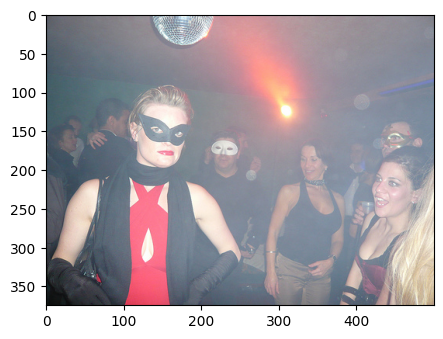

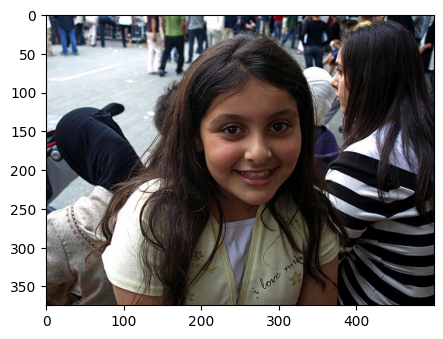

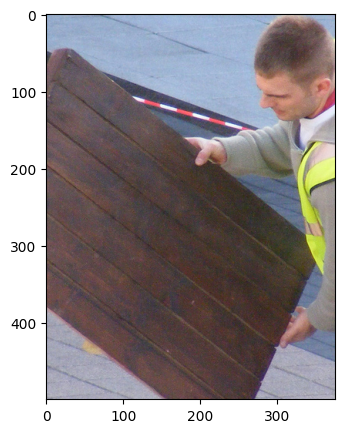

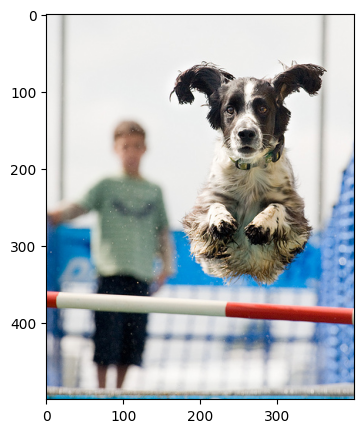

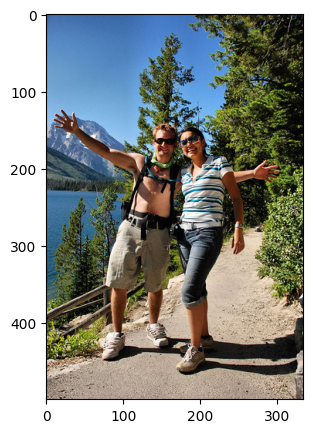

In [33]:
for i in range(5):
    plt.figure(figsize=(5,5))
    img = cv2.imread(images[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

In [34]:
inception_model = ResNet50(include_top=True)
inception_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       


1. **ResNet50 Architecture**: ResNet50 is a convolutional neural network architecture that consists of 50 layers. It was introduced by Microsoft Research and is renowned for its ability to train very deep neural networks effectively. The key innovation in ResNet50 is the introduction of residual connections, also known as skip connections, which alleviate the vanishing gradient problem in deep networks. These connections allow gradients to flow more easily during training, enabling the training of much deeper networks.

2. **include_top=True**: In Keras, when creating a model instance with `include_top=True`, it includes the fully connected layers (or the "top" layers) of the network. In the case of ResNet50, these top layers consist of dense layers that perform classification based on the features extracted by the preceding convolutional layers. These top layers are typically trained on the ImageNet dataset, which consists of millions of labeled images across thousands of categories.


In [35]:
last = inception_model.layers[-2].output # Output of the penultimate layer of ResNet model 
model = Model(inputs=inception_model.input,outputs=last)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        


1. **`last = inception_model.layers[-2].output`**: This line retrieves the output tensor of the penultimate layer of the original ResNet50 model (`inception_model`). In neural network models, layers are indexed from 0, so `-2` refers to the second-to-last layer. This penultimate layer typically contains highly abstract and semantically rich representations of the input images learned during the training process.

2. **`model = Model(inputs=inception_model.input, outputs=last)`**: This line creates a new `Model` object using the Keras Functional API. It specifies the inputs and outputs of the new model. The inputs are set to be the same as the inputs of the original ResNet50 model (`inception_model.input`), while the outputs are set to be the output tensor of the penultimate layer (`last`). Essentially, this new model will take the same inputs as the original ResNet50 model but will output the activations of the penultimate layer instead of the final classification layer.




In [36]:
resnet_features_file = '/Users/srisaijishnuedara/Documents/SEMESTER_6/ML_PROJECT/image_captioning/RESULTS/resnet_features_1.npy'

In [31]:
resnet_features = {}


In [32]:
count = 0

for img_path in tqdm(images):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(224,224)) # ResNet model requires images of dimensions (224,224,3)
    img = img.reshape(1,224,224,3) # Reshaping image to the dimensions of a single image
    features = model.predict(img).reshape(2048,) # Feature extraction from images
    img_name = img_path.split('/')[-1] # Extracting image name
    resnet_features[img_name] = features
    count += 1
    # Fetching the features of only 1500 images 
    if count == 1500:
        break
    if count % 50 == 0:
        print(count)

  0%|          | 0/8091 [00:00<?, ?it/s]

1/1 [==============================] - 0s 54ms/step
50
1/1 [==============================] - 0s 62ms/step
100
1/1 [==============================] - 0s 55ms/step
150
1/1 [==============================] - 0s 57ms/step
200
1/1 [==============================] - 0s 64ms/step
250
1/1 [==============================] - 0s 56ms/step
300
1/1 [==============================] - 0s 66ms/step
350
1/1 [==============================] - 0s 59ms/step
400
1/1 [==============================] - 0s 69ms/step
450
1/1 [==============================] - 0s 68ms/step
500
1/1 [==============================] - 0s 65ms/step
550
1/1 [==============================] - 0s 67ms/step
600
1/1 [==============================] - 0s 64ms/step
650
1/1 [==============================] - 0s 65ms/step
700
1/1 [==============================] - 0s 64ms/step
750
1/1 [==============================] - 0s 63ms/step
800
1/1 [==============================] - 0s 58ms/step
850
1/1 [==============================] - 0s 63ms/st


1. **Looping through Images**: The code iterates through a list of image paths (`images`). The `tqdm` function is used to create a progress bar for visual feedback on the iteration progress.

2. **Reading and Preprocessing Images**: For each image path, the code reads the image using OpenCV (`cv2.imread`), converts it from BGR to RGB color space (`cv2.cvtColor`), and resizes it to match the input dimensions expected by the ResNet50 model (224x224 pixels).

3. **Reshaping Image**: The image is reshaped into a 4D tensor with shape `(1, 224, 224, 3)`, where the first dimension represents the batch size (in this case, only one image).

4. **Feature Extraction**: The preprocessed image is then passed through the model (`model.predict`) to obtain the activations of the penultimate layer (features). The result is reshaped into a 1D array with 2048 elements, corresponding to the number of output channels of the penultimate layer.

5. **Storing Features**: The extracted features are stored in a dictionary (`resnet_features`) using the image name as the key.


In [33]:
np.save(resnet_features_file, resnet_features)

In [37]:
resnet_features = np.load(resnet_features_file, allow_pickle=True).item()

In [38]:
# Preprocessing the captions text
captions = captions[1:]

captions_dict = {}

for cap in captions:
    try:
        img_name = cap.split(',')[0]
        caption = cap.split(',')[1]
        # Each image has 5 captions
        if img_name in resnet_features:
            if img_name not in captions_dict:
                captions_dict[img_name] = [caption] # Storing the first caption
            else:
                captions_dict[img_name].append(caption) # Adding the remaining captions
    except:
        break

len(captions_dict)

1500


1. **Removing Header**: The first line `captions = captions[1:]` removes the header from the captions data, assuming it contains metadata or column names.

2. **Inspecting Captions**: `captions[:5]` prints the first five captions to inspect the format of the captions data.

3. **Extracting Captions**: `captions[8].split(',')[1]` extracts the caption associated with the 8th image (assuming the index starts from 0) by splitting the string on commas and selecting the second element. This assumes that each caption is stored as a string in the format `"image_name, caption"`.

4. **Creating Captions Dictionary**: The `captions_dict` dictionary is created to store image names as keys and lists of associated captions as values.

5. **Looping through Captions**: The loop iterates through each caption in the `captions` list. Within the loop:
   - It splits each caption string into image name and caption using `split(',')`.
   - Checks if the image name is present in the `resnet_features` dictionary (which presumably contains feature vectors extracted from images).
   - If the image name is present in `resnet_features`, it checks if the image name is already in `captions_dict`.
   - If the image name is not present in `captions_dict`, it adds the image name as a key and initializes the value with a list containing the caption.
   - If the image name is already in `captions_dict`, it appends the caption to the existing list of captions for that image.

6. **Captions Count**: `len(captions_dict)` provides the number of unique images for which captions are available in the dataset.



In [39]:
# Function to preprocess text
def text_preprocess(text):
    modified_text = text.lower() # Converting text to lowercase
    modified_text = 'startofseq ' + modified_text + ' endofseq' # Appending the special tokens at the beginning and ending of text
    return modified_text

# Storing the preprocessed text within the captions dictionary
for key, val in captions_dict.items():
    for item in val:
        captions_dict[key][val.index(item)] = text_preprocess(item)

count_words = dict()
cnt = 1

for key, val in captions_dict.items(): # Iterating through all images with keys as images and their values as 5 captions
    for item in val: # Iterating through all captions for each image
        for word in item.split(): # Iterating through all words in each caption
            if word not in count_words:
                count_words[word] = cnt
                cnt += 1

len(count_words) # Vocab size

3874


1. **`text_preprocess` Function**: This function preprocesses a given text by:
   - Converting the text to lowercase using `lower()` method to ensure consistency.
   - Adding special tokens `"startofseq "` at the beginning and `" endofseq"` at the end of the text. These tokens mark the start and end of a sequence, which is commonly used in sequence-to-sequence models like those used in machine translation or image captioning tasks.

2. **Storing Preprocessed Text**: The loop `for key, val in captions_dict.items()` iterates through each image-caption pair in the `captions_dict` dictionary. Within the loop:
   - Each caption associated with the image is preprocessed using the `text_preprocess` function.
   - The preprocessed caption replaces the original caption in the `captions_dict` dictionary.

3. **Counting Words**: The loop `for key, val in captions_dict.items()` is used again to iterate through each image-caption pair in the `captions_dict` dictionary. Within this loop:
   - Each caption associated with the image is split into words using `split()`.
   - For each word in the caption, if the word is not already present in the `count_words` dictionary, it is added to the dictionary with a unique index (`cnt`). This effectively builds a vocabulary where each word is assigned a unique index.

4. **Vocabulary Size**: `len(count_words)` calculates the number of unique words in the vocabulary, which represents the vocabulary size.


In [40]:
# Encoding the text by assigning each word to its corresponding index in the vocabulary i.e. count_words dictionary
for key, val in captions_dict.items():
    for caption in val:
        encoded = []
        for word in caption.split():
            encoded.append(count_words[word])
        captions_dict[key][val.index(caption)] = encoded
        
# Determining the maximum possible length of text within the entire captions text corpus
max_len = -1

for key, value in captions_dict.items():
    for caption in value:
        if max_len < len(caption):
            max_len = len(caption)

max_len

34



1. **Encoding Text**:
   - The loop `for key, val in captions_dict.items()` iterates through each image-caption pair in the `captions_dict` dictionary.
   - Within this loop, another loop iterates through each caption associated with the image (`for caption in val`).
   - For each caption, the loop splits the caption into words using `split()`.
   - For each word in the caption, it retrieves the corresponding index from the `count_words` dictionary and appends it to a list (`encoded`).
   - Finally, the original caption in `captions_dict` is replaced with its encoded representation (`captions_dict[key][val.index(caption)] = encoded`).

2. **Determining Maximum Length**:
   - The variable `max_len` is initialized to `-1`.
   - Another loop `for key, value in captions_dict.items()` iterates through each image-caption pair in the `captions_dict` dictionary.
   - Within this loop, another loop iterates through each caption associated with the image (`for caption in value`).
   - For each caption, it compares the length of the encoded representation (`len(caption)`) with the current maximum length (`max_len`).
   - If the length of the encoded representation is greater than the current `max_len`, `max_len` is updated to the length of the encoded representation.

3. **Maximum Length Determination**:
   - `max_len` now holds the maximum possible length of text within the entire captions corpus, considering all images and their associated captions.



In [41]:
vocab_size = len(count_words) # Vocab size is the total number of words present in count_words dictionary
vocab_size


3874

In [42]:
def generator(img,caption):
    n_samples = 0
    X = []
    y_input = []
    y_output = []
    
    for key, val in caption.items(): 
        for item in val: 
            for i in range(1,len(item)):
                X.append(img[key]) # Appending the input image features
                input_seq = [item[:i]] # Previously generated text to be used as input to predict the next word 
                output_seq = item[i] # The next word to be predicted as output
                # Padding encoded text sequences to the maximum length
                input_seq = pad_sequences(input_seq,maxlen=max_len,padding='post',truncating='post')[0] 
                # One Hot encoding the output sequence with vocabulary size as the total no. of classes
                output_seq = to_categorical([output_seq],num_classes=vocab_size+1)[0]
                y_input.append(input_seq)
                y_output.append(output_seq)
    
    return X, y_input, y_output

X, y_in, y_out = generator(resnet_features,captions_dict)



1. **Function Signature**: The function takes two arguments, `img` and `caption`. `img` likely contains features extracted from images (such as from a convolutional neural network), while `caption` contains preprocessed captions associated with those images.

2. **Initialization**: Inside the function, variables `X`, `y_input`, and `y_output` are initialized to empty lists. These lists will be populated with training samples.

3. **Looping through Captions**:
   - The nested loops iterate over each image-caption pair in the `caption` dictionary.
   - For each caption associated with an image, it generates training samples by considering subsequences of the caption.
   - `for i in range(1, len(item))`: This loop starts from 1 because we're considering subsequences, and ends at the length of the caption.
   
4. **Data Preparation**:
   - `X.append(img[key])`: Appends the image features corresponding to the current caption.
   - `input_seq = [item[:i]]`: Constructs the input sequence for the model, which consists of the first `i` words of the caption.
   - `output_seq = item[i]`: Identifies the next word in the caption, which is the target output for the model.
   - `pad_sequences`: Ensures that all input sequences have the same length by padding or truncating them to match the `max_len` determined earlier.
   - `to_categorical`: Converts the output sequence into one-hot encoded format to represent the target word as a vector of binary values.

5. **Return**: The function returns the generated training samples: `X` (image features), `y_input` (input sequences), and `y_output` (target output sequences).



In [45]:
# Define the directory paths to save the arrays
X_file = '/Users/srisaijishnuedara/Documents/SEMESTER_6/AI__PROJECT/image_captioning/X.npy'
y_in_file = '/Users/srisaijishnuedara/Documents/SEMESTER_6/AI__PROJECT/image_captioning/y_in.npy'
y_out_file = '/Users/srisaijishnuedara/Documents/SEMESTER_6/AI__PROJECT/image_captioning/y_out.npy'

In [39]:
len(X), len(y_in), len(y_out)


(91866, 91866, 91866)

In [43]:
# Converting input and output into Numpy arrays for faster processing
X = np.array(X)
y_in = np.array(y_in,dtype='float64')
y_out = np.array(y_out,dtype='float64')

X.shape, y_in.shape, y_out.shape

((91866, 2048), (91866, 34), (91866, 3875))


1. **Conversion to NumPy Arrays**:
   - `np.array(X)`: Converts the list `X` containing image features into a NumPy array. This is a common practice because NumPy arrays offer efficient storage and manipulation of numerical data, providing better performance compared to Python lists.
   - `np.array(y_in, dtype='float64')`: Converts the list `y_in` containing input sequences into a NumPy array with a data type of `'float64'`. Similarly, `np.array(y_out, dtype='float64')` converts the list `y_out` containing output sequences into a NumPy array with the same data type.
   - Specifying `dtype='float64'` ensures that the elements in the arrays are represented as 64-bit floating-point numbers, which is a common data type for numerical computations.

2. **Purpose of Conversion**:
   - **Faster Processing**: NumPy arrays are optimized for numerical operations and provide faster processing compared to Python lists, especially when dealing with large datasets.
   - **Compatibility with Libraries**: Many machine learning and deep learning libraries, such as TensorFlow and PyTorch, expect input data in the form of NumPy arrays. Converting the data into NumPy arrays ensures compatibility with these libraries.
   - **Memory Efficiency**: NumPy arrays are more memory-efficient than Python lists, which is important when dealing with large datasets, as it helps in reducing memory usage and improving overall performance.

3. **Resulting Shapes**:
   - After conversion, the code prints the shapes of the NumPy arrays `X`, `y_in`, and `y_out` using the `shape` attribute. This provides information about the dimensions of the arrays, which is useful for verifying data integrity and compatibility with subsequent operations.



In [46]:
# Save X, y_in, and y_out to files
np.save(X_file, X)
np.save(y_in_file, y_in)
np.save(y_out_file, y_out)

In [47]:
embedding_len = 128
MAX_LEN = max_len
vocab_size = len(count_words)

# Model for image feature extraction
img_model = Sequential()
img_model.add(Dense(embedding_len,input_shape=(2048,),activation='relu'))
img_model.add(RepeatVector(MAX_LEN))

img_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               262272    
                                                                 
 repeat_vector (RepeatVecto  (None, 34, 128)           0         
 r)                                                              
                                                                 
Total params: 262272 (1.00 MB)
Trainable params: 262272 (1.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________



1. **Model Architecture**:
   - The model is defined using the Keras Sequential API, which allows stacking layers sequentially.
   - The model consists of two layers:
     - `Dense` layer: This layer is added to process the image features. It has an input shape of (2048,), which corresponds to the number of features extracted from the images. The layer contains 128 neurons and uses the ReLU activation function.
     - `RepeatVector` layer: This layer repeats the input `embedding_len` times to match the desired sequence length (`MAX_LEN`). This is useful for matching the dimensions of the output sequences from the text processing part of the model.

2. **Model Summary Output**:
   - The output of `img_model.summary()` provides a summary of the model architecture, including:
     - The layer type (`Dense` and `RepeatVector`).
     - The output shape of each layer. The output shape of the `Dense` layer is (None, 128), indicating that it produces an output with 128 features. The output shape of the `RepeatVector` layer is (None, 34, 128), indicating that it repeats the input 128-dimensional vector 34 times to produce a sequence of shape (None, 34, 128).
     - The number of parameters in each layer. The `Dense` layer has 262,272 parameters (128 * 2048 + 128), where 2048 is the input dimension and 128 is the number of neurons. The `RepeatVector` layer does not have trainable parameters.

3. **Parameters**:
   - `embedding_len = 128`: This variable defines the dimensionality of the embedding space for image features.
   - `MAX_LEN`: This variable specifies the maximum length of sequences expected as output from the model.
   - `vocab_size`: This variable represents the size of the vocabulary, which is the total number of unique words in the captions.

4. **Explanation**:
   - The purpose of this model is to process image features and prepare them for merging with the textual information in a multimodal model. The `Dense` layer transforms the high-dimensional image features into a lower-dimensional embedding space, while the `RepeatVector` layer repeats this embedding to match the length of the textual sequences.



In [48]:
# Model for generating captions from image features
captions_model = Sequential()
captions_model.add(Embedding(input_dim=vocab_size+1,output_dim=embedding_len,input_length=MAX_LEN))
captions_model.add(LSTM(256,return_sequences=True))
captions_model.add(TimeDistributed(Dense(embedding_len)))

captions_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 34, 128)           496000    
                                                                 
 lstm (LSTM)                 (None, 34, 256)           394240    
                                                                 
 time_distributed (TimeDist  (None, 34, 128)           32896     
 ributed)                                                        
                                                                 
Total params: 923136 (3.52 MB)
Trainable params: 923136 (3.52 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________



1. **Model Architecture**:
   - The model is again defined using the Keras Sequential API.
   - It consists of three layers:
     - `Embedding` layer: This layer converts integer indices (representing words) into dense vectors of fixed size. It has `vocab_size + 1` as the input dimension, `embedding_len` as the output dimension, and `MAX_LEN` as the input length.
     - `LSTM` layer: This is a Long Short-Term Memory (LSTM) layer, a type of recurrent neural network (RNN) layer capable of learning long-term dependencies in sequential data. It has 256 units and `return_sequences=True`, meaning it returns the full sequence of outputs for each timestep.
     - `TimeDistributed` layer followed by a `Dense` layer: The `TimeDistributed` layer allows the dense layer to be applied to each timestep independently, which is necessary when dealing with sequences. The dense layer maps the output of the LSTM layer to a space with `embedding_len` dimensions.

2. **Model Summary Output**:
   - The output of `captions_model.summary()` provides a summary of the model architecture, including:
     - The layer type (`Embedding`, `LSTM`, `TimeDistributed`).
     - The output shape of each layer. The output shape of the `Embedding` layer is (None, 34, 128), indicating that it produces a sequence of vectors with 128 dimensions for each of the 34 timesteps. The output shape of the `LSTM` layer is also (None, 34, 256), indicating that it returns a sequence of outputs for each timestep. The output shape of the `TimeDistributed` layer is (None, 34, 128), matching the input dimensions.
     - The number of parameters in each layer. The `Embedding` layer has 496,000 parameters, the `LSTM` layer has 394,240 parameters, and the `TimeDistributed` layer has 32,896 parameters.

3. **Parameters**:
   - `vocab_size`: Represents the size of the vocabulary, which is the total number of unique words in the captions.
   - `embedding_len = 128`: Specifies the dimensionality of the word embeddings.
   - `MAX_LEN`: Specifies the maximum length of sequences expected as input to the model.

4. **Explanation**:
   - This model takes the image features as input and generates captions for the corresponding images. The `Embedding` layer converts the integer indices of words into dense vectors. The `LSTM` layer processes these dense vectors while retaining memory of previous words in the sequence. The `TimeDistributed` layer applies a dense transformation to each timestep independently, allowing the model to output a caption for each timestep.



In [49]:
# Concatenating the outputs of image and caption models
concat_output = Concatenate()([img_model.output,captions_model.output])
# First LSTM Layer
output = LSTM(units=128,return_sequences=True)(concat_output)
# Second LSTM Layer
output = LSTM(units=512,return_sequences=False)(output)
# Output Layer 
output = Dense(units=vocab_size+1,activation='softmax')(output)
# Creating the final model
final_model = Model(inputs=[img_model.input,captions_model.input],outputs=output)
final_model.compile(loss='categorical_crossentropy',optimizer='RMSprop',metrics='accuracy')
final_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 embedding_input (InputLaye  [(None, 34)]                 0         []                            
 r)                                                                                               
                                                                                                  
 dense_input (InputLayer)    [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 34, 128)              496000    ['embedding_input[0][0]']     
                                                                                                  
 dense (Dense)               (None, 128)                  262272    ['dense_input[0][0]']   


1. **Concatenating Image and Caption Models**:
   - The output of the image model (`img_model.output`) and the output of the caption model (`captions_model.output`) are concatenated using the `Concatenate` layer. This combines the features extracted from the image with the features extracted from the captions.

2. **LSTM Layers**:
   - Two LSTM layers are added to the concatenated output:
     - The first LSTM layer (`LSTM(units=128, return_sequences=True)`) has 128 units and returns sequences (`return_sequences=True`). It processes the concatenated features and outputs sequences of the same length.
     - The second LSTM layer (`LSTM(units=512, return_sequences=False)`) has 512 units and does not return sequences (`return_sequences=False`). It processes the sequences outputted by the first LSTM layer and produces a single output for each sequence.

3. **Output Layer**:
   - After the LSTM layers, a dense layer with `softmax` activation is added as the output layer (`Dense(units=vocab_size+1, activation='softmax')`). This layer predicts the probability distribution over the vocabulary for each time step.

4. **Model Compilation**:
   - The final model is compiled using the categorical cross-entropy loss function (`loss='categorical_crossentropy'`), RMSprop optimizer (`optimizer='RMSprop'`), and accuracy as the evaluation metric (`metrics='accuracy'`).

5. **Model Summary Output**:
   - The output of `final_model.summary()` provides a comprehensive summary of the model architecture.
   - It lists all the layers in the model, including their types, output shapes, and the number of parameters.
   - It also indicates the connections between the layers, showing how inputs and outputs of different layers are connected.

6. **Parameters**:
   - The total number of parameters in the final model is 4,683,171 (approximately 17.86 MB), making it a relatively large model.
   - These parameters include weights and biases of the dense layers and the recurrent weights of the LSTM layers.

In summary, this final model combines image features and textual information to generate captions for images. The model architecture includes LSTM layers for sequence processing and a dense output layer for predicting the next word in the caption sequence. The model is compiled for training using appropriate loss and optimization functions.

In [23]:
# Visualizing the model architecture
plot_model(final_model, 'model.png', show_shapes=True, dpi=100)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [25]:
print("Shapes of X, y_in, y_out:")
print(X.shape, y_in.shape, y_out.shape)

Shapes of X, y_in, y_out:
(92039, 11000) (92039, 34) (92039, 3911)


In [ ]:
mc = ModelCheckpoint('image_caption_generator.h5',monitor='accuracy',verbose=1,mode='max',save_best_only=True)

final_model.fit([X,y_in],
                y_out,
                batch_size=512,
                callbacks=mc,
                epochs=100)

In [44]:
# Creating an inverse dictionary with reverse key-value pairs
inverse_dict = {val: key for key,val in count_words.items()}

Creating an inverse dictionary with reverse key-value pairs serves the purpose of mapping encoded numerical indices back to their corresponding words in the vocabulary. This is particularly useful when generating captions using the model because the output of the model is typically a sequence of encoded indices representing words in the vocabulary.

Here's why we are doing this:

1. **Mapping from Indices to Words**:
   - During the training process, words from captions were encoded into numerical indices using the `count_words` dictionary. These indices represent the position of the words in the vocabulary.
   - When generating captions from the model, the output will be a sequence of these numerical indices.
   - By creating an inverse dictionary, we can map these numerical indices back to their corresponding words in the vocabulary.

2. **Interpretability**:
   - Mapping indices back to words makes the output captions more interpretable and understandable.
   - Instead of dealing with numerical indices, we can convert them back to their corresponding words, which provides meaningful and human-readable captions.

3. **Evaluation and Visualization**:
   - Having words instead of indices allows for easier evaluation of the generated captions, especially when comparing them to reference captions.
   - It also facilitates visualization of the generated captions alongside the input images, making it easier to understand the performance of the model.

By creating an inverse dictionary, we ensure that we can easily interpret and evaluate the output of the model in terms of words, which is crucial for image captioning where the quality and relevance of generated captions are essential.

In [45]:
import tensorflow.keras.models as tf_models
final_model = tf_models.load_model('/Users/srisaijishnuedara/Documents/SEMESTER_6/ML_PROJECT/image_captioning/image_caption_generator.h5')
final_model_dct=final_model = tf_models.load_model('/Users/srisaijishnuedara/Documents/SEMESTER_6/ML_PROJECT/image_captioning/image_caption_generator_dct.h5')


In [46]:
# Custom function for extracting an image and transforming it into an appropriate format
def getImage(idx):
    test_img_path = images[idx]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
    test_img = cv2.resize(test_img,(224,224))
    test_img = np.reshape(test_img,(1,224,224,3))
    return test_img

In [47]:
def match_image_name(image_path, captions_dict):
    for image_filename in captions_dict.keys():
        if image_filename in image_path:
            return image_filename
    return None

This custom function `getImage(idx)` is designed to extract an image from a specified index in a list of image paths and transform it into an appropriate format for processing or prediction. Here's why we are doing this:

1. **Index-Based Image Retrieval**:
   - The function takes an index (`idx`) as input, allowing us to specify which image from the list of image paths (`images`) we want to retrieve.
   - This indexing mechanism enables us to select a particular image for further processing or analysis.

2. **Image Transformation**:
   - The function reads the image using OpenCV (`cv2.imread(test_img_path)`) and converts it from BGR to RGB color space (`cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)`). This ensures consistency in color representation across different libraries and frameworks.
   - It resizes the image to a standard size of 224x224 pixels (`cv2.resize(test_img, (224, 224)`), which is a common input size for many deep learning models trained on image data.
   - The image is reshaped into a 4D array with shape `(1, 224, 224, 3)` to comply with the expected input shape for models that process images. The additional dimension `(1,)` indicates that it's a single image batch.




1/1 [==============================] - 0s 22ms/step


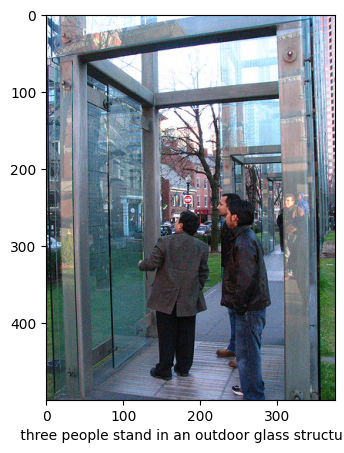

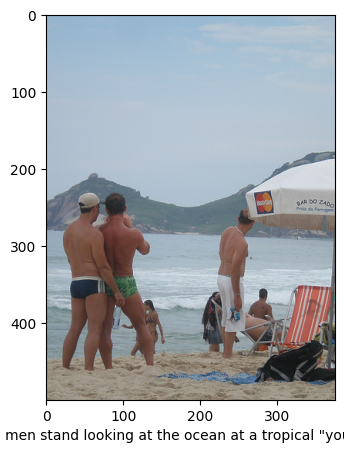

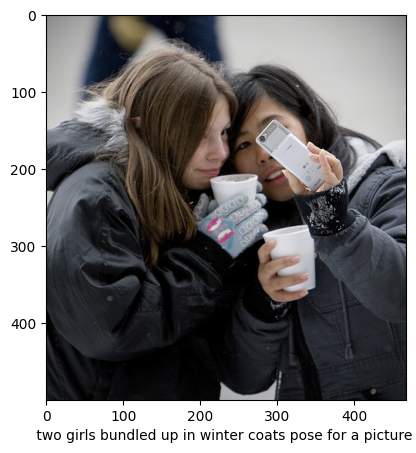

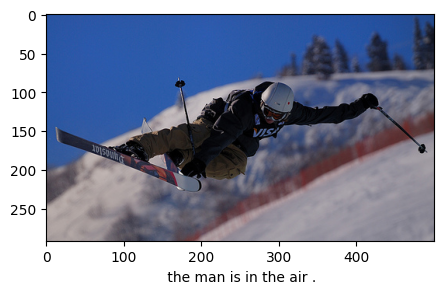

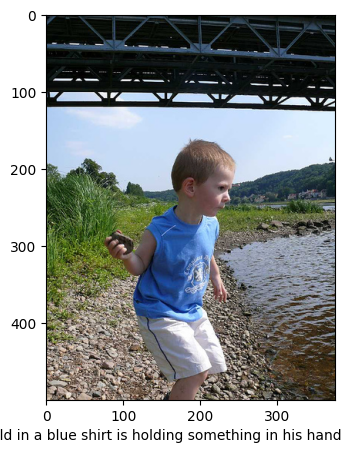

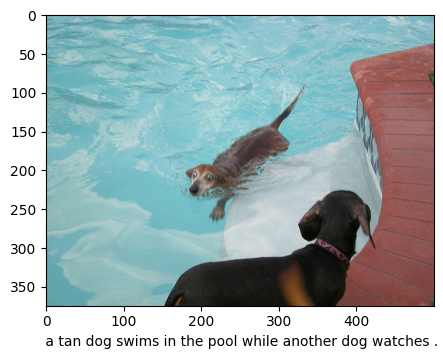

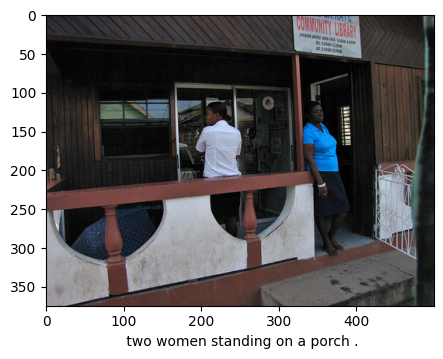

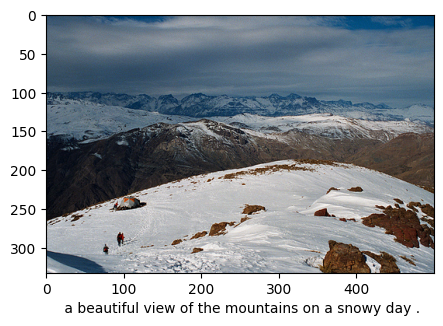

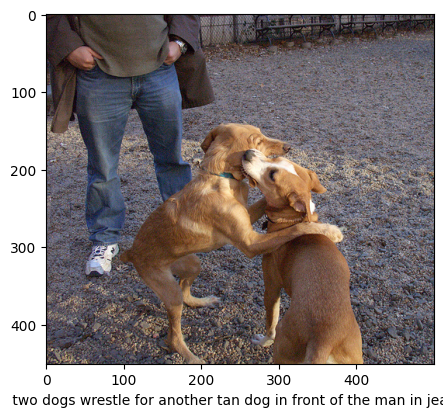

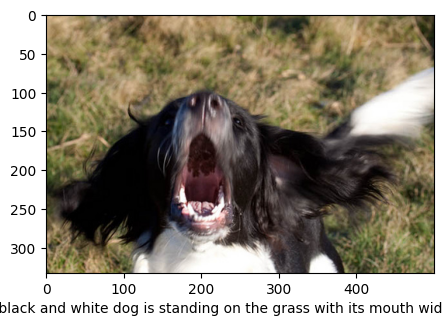

In [48]:
for i in range(10):
    random_no = np.random.randint(0,1501,(1,1))[0,0]
    test_feature = model.predict(getImage(random_no)).reshape(1,2048)
    test_img_path = images[random_no]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
    pred_text = ['startofseq']
    count = 0
    caption = '' # Stores the predicted captions text
    
    while count < 25:
        count += 1
        # Encoding the captions text with numbers
        encoded = []
        
        for i in pred_text:
            encoded.append(count_words[i])
        
        encoded = [encoded]
        # Padding the encoded text sequences to maximum length
        encoded = pad_sequences(encoded,maxlen=34,padding='post',truncating='post')
        pred_idx = np.argmax(final_model.predict([test_feature,encoded])) # Fetching the predicted word index having the maximum probability of occurrence
        sampled_word = inverse_dict[pred_idx] # Extracting the predicted word by its respective index
        # Checking for ending of the sequence
        if sampled_word == 'endofseq':
            break
        caption = caption + ' ' + sampled_word
        pred_text.append(sampled_word)
    
    plt.figure(figsize=(5,5))
    plt.imshow(test_img)
    plt.xlabel(caption)

1/1 [==============================] - 0s 23ms/step
Predicted Text:
a child skis across the snowy ground .


The ROUGE score is: {'rouge1': 0.2222222222222222, 'rouge2': 0.19672131147540983, 'rougeL': 0.2222222222222222, 'rougeLsum': 0.2222222222222222}
Bleu_Score -1 = 0.500000
a child skis across the snowy ground .


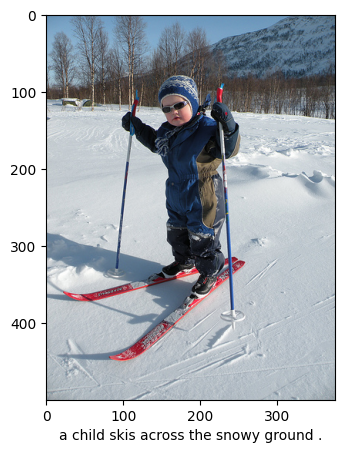

In [49]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from evaluate import load
# Load the ROUGE metric
import evaluate
#from pycocoevalcap.spice.spice import Spice
#warnings.filterwarnings('ignore')
from nltk.translate.bleu_score import corpus_bleu
from queue import PriorityQueue

image_names = []
actual_captions = []
predicted_captions = []
bleu1_scores = []
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []
rougeLsum_scores = []
beam_width = 3  # Define the beam width

for i in range(1):
    random_no = np.random.randint(0,1501,(1,1))[0,0]
    test_feature = model.predict(getImage(random_no)).reshape(1,2048)
    test_img_path = images[random_no]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
    actual_captions_dict = {}

    # Load actual captions from captions.txt file
    with open('/Users/srisaijishnuedara/Documents/SEMESTER_6/ML_PROJECT/image_captioning/data/captions.txt', 'rt', encoding='utf-8') as file:
        for line in file:
            parts = line.strip().split(',')
            if len(parts) == 2:
                image_filename, caption = parts
                if image_filename in actual_captions_dict:
                    actual_captions_dict[image_filename].append(caption)
                else:
                    actual_captions_dict[image_filename] = [caption]

    # Get the matching image filename
    test_img_path=test_img_path.split("/")[-1]
    image_filename = match_image_name(test_img_path, actual_captions_dict)
    # test_feature = model.predict([getImage(random_no),actual_captions_dict[random_no]]).reshape(1,2048)
    if image_filename:
        actual_captions_list = actual_captions_dict[image_filename]
        actual_captions_str = ' '.join(actual_captions_list)
    else:
        print("No matching image filename found for:", test_img_path)

    # Initialize the beam with the start token
    beam = [{'sequence': ['startofseq'], 'score': 1.0}]

    # Generate captions using beam search
    for _ in range(50):  # Maximum caption length
        candidates = []
        for b in beam:
            # Encoding the current sequence
            encoded = [count_words[word] for word in b['sequence']]
            encoded = pad_sequences([encoded], maxlen=34, padding='post', truncating='post')

            # Predict the next word for the current sequence
            predictions = final_model.predict([test_feature, encoded])[0]

            # Get top-k predictions
            top_indices = np.argsort(predictions)[-beam_width:]

            # Generate candidate captions
            for idx in top_indices:
                candidate = {
                    'sequence': b['sequence'] + [inverse_dict[idx]],
                    'score': b['score'] * predictions[idx]
                }
                candidates.append(candidate)

        # Select top-k candidates based on score
        beam = sorted(candidates, key=lambda x: x['score'], reverse=True)[:beam_width]

        # Check for end token in the beam
        end_found = False
        for b in beam:
            if b['sequence'][-1] == 'endofseq':
                end_found = True
                break

        if end_found:
            break

    # Get the best caption from the beam
    pred_caption = beam[0]['sequence']
    pred_caption = pred_caption[1:-1]  # Remove start and end tokens
    pred_caption = ' '.join(pred_caption)
    print(f'Predicted Text:\n{pred_caption}')
    # Compute ROUGE scores
    rouge = evaluate.load('rouge')
    results = rouge.compute(predictions= [pred_caption], references=[actual_captions_str])
    print(f"The ROUGE score is: {results}")

    # Calculate BLEU scores
    Bleu1 = corpus_bleu([actual_captions_str], [pred_caption], weights=(1, 0, 0, 0))
   
    # Print BLEU scores
    print('Bleu_Score -1 = %f' % Bleu1)

   # Append data to lists
    image_names.append(image_filename)
    actual_captions.append(actual_captions_str)
    predicted_captions.append(pred_caption)
    bleu1_scores.append(Bleu1)
    rouge1_scores.append(results['rouge1'])
    rouge2_scores.append(results['rouge2'])
    rougeL_scores.append(results['rougeL'])
    rougeLsum_scores.append(results['rougeLsum'])

    # Create DataFrame
    data = {
        'Image Name': image_names,
        'Actual Caption': actual_captions,
        'Predicted Caption': predicted_captions,
        'BLEU1 Score': bleu1_scores,
        'ROUGE1 Score': rouge1_scores,
        'ROUGE2 Score': rouge2_scores,
        'ROUGEL Score': rougeL_scores,
        'ROUGELsum Score': rougeLsum_scores
    }

    df = pd.DataFrame(data)

    # Write DataFrame to CSV file
    df.to_csv('caption_scores_beam.csv', index=False)
    print(pred_caption)
    plt.figure(figsize=(5,5))
    plt.imshow(test_img)
    plt.xlabel(pred_caption)

This code segment is responsible for generating captions for randomly selected images using beam search, computing evaluation metrics (BLEU and ROUGE scores), and storing the results in a CSV file. Let's break down the code and its concepts:

1. **Random Image Selection**:
   - A random integer (`random_no`) is generated to select a random image from the dataset.
   - The image features are extracted using the pre-trained model (`model.predict(getImage(random_no)).reshape(1,2048)`), and the corresponding image path is retrieved.

2. **Loading Actual Captions**:
   - Actual captions are loaded from the captions.txt file and stored in a dictionary (`actual_captions_dict`). Each image filename is associated with a list of its actual captions.

3. **Beam Search for Caption Generation**:
   - Beam search is performed to generate captions for the selected image. It iteratively expands the search space by considering multiple candidate captions and selecting the ones with the highest scores.
   - The beam is initialized with a single sequence containing the start token.
   - For each iteration, the model predicts the next word given the current sequence using the final model (`final_model.predict`).
   - Top-k predictions are selected based on their probabilities, and candidate captions are generated by appending the predicted words to the current sequences.
   - The beam is updated with the top-k candidates, and the process continues until either the maximum caption length is reached or the end token is predicted.

4. **Evaluation Metrics Calculation**:
   - ROUGE scores are computed using the `evaluate.load('rouge').compute` function from the `evaluate` module. ROUGE (Recall-Oriented Understudy for Gisting Evaluation) measures the overlap between predicted and reference texts.
   - BLEU scores are calculated using the `corpus_bleu` function from NLTK. BLEU (Bilingual Evaluation Understudy) evaluates the similarity between the predicted and reference texts based on n-gram matches.

5. **Data Storage and Visualization**:
   - The image filename, actual caption, predicted caption, and evaluation scores are stored in lists.
   - These lists are used to create a DataFrame (`df`) containing all the data.
   - The DataFrame is written to a CSV file named 'caption_scores_beam.csv'.
   - Finally, the selected image is displayed along with the predicted caption using Matplotlib.



1/1 [==============================] - 0s 23ms/step
Predicted Text:
[' a black dog jumps into the water to catch a red and blue frisbee']
The rouge score is: {'rouge1': 0.33333333333333337, 'rouge2': 0.3170731707317073, 'rougeL': 0.2857142857142857, 'rougeLsum': 0.2857142857142857}
Bleu_Score -1 = 0.338462


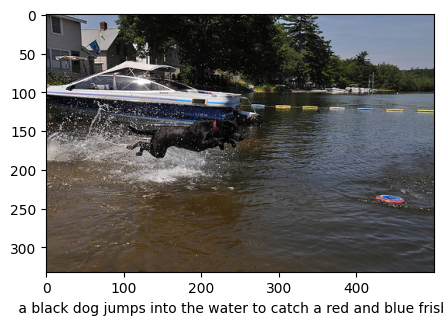

In [27]:
import cv2
import os

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from evaluate import load
# Load the ROUGE metric
import evaluate
warnings.filterwarnings('ignore')
from nltk.translate.bleu_score import corpus_bleu
#from nltk.translate.meteor_score import meteor_score

def match_image_name(image_path, captions_dict):
    for image_filename in captions_dict.keys():
        if image_filename in image_path:
            return image_filename
    return None
# Initialize lists to store data
image_names = []
actual_captions = []
predicted_captions = []
bleu1_scores = []
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []
rougeLsum_scores = []

for i in range(1):
    random_no = np.random.randint(0,1501,(1,1))[0,0]
    test_feature = model.predict(getImage(random_no)).reshape(1,2048)
    test_img_path = images[random_no]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
    actual_captions_dict = {}
    
    # Load actual captions from captions.txt file
    with open('/Users/srisaijishnuedara/Documents/SEMESTER_6/AI__PROJECT/image_captioning/data/captions.txt', 'rt', encoding='utf-8') as file:
        for line in file:
            parts = line.strip().split(',')
            if len(parts) == 2:
                image_filename, caption = parts
                if image_filename in actual_captions_dict:
                    actual_captions_dict[image_filename].append(caption)
                else:
                    actual_captions_dict[image_filename] = [caption]

   # Get the matching image filename
    test_img_path=test_img_path.split("/")[-1]
    image_filename = match_image_name(test_img_path, actual_captions_dict)

    #test_feature = model.predict([getImage(random_no),actual_captions_dict[random_no]]).reshape(1,2048)
    if image_filename:
        actual_captions_list = actual_captions_dict[image_filename]
        actual_captions_str = ' '.join(actual_captions_list)            
    else:
        print("No matching image filename found for:", test_img_path)
    
    pred_text = ['startofseq']
    count = 0
    caption = '' # Stores the predicted captions text
    
    while count < 25:
        count += 1
        encoded = []
        
        for word in pred_text:
            encoded.append(count_words[word])
        
        encoded = [encoded]
        encoded = pad_sequences(encoded,maxlen=34,padding='post',truncating='post')
        pred_idx = np.argmax(final_model_dct.predict([test_feature,encoded]))
        sampled_word = inverse_dict[pred_idx]
        
        if sampled_word == 'endofseq':
            break
        caption = caption + ' ' + sampled_word
        pred_text.append(sampled_word)
    pred_caption = [caption]
    print(f'Predicted Text:\n{pred_caption}')
        
    # Compute ROUGE scores
    rouge = evaluate.load('rouge')
    results = rouge.compute(predictions=pred_caption, references=[actual_captions_str])
    print(f"The rouge score is: {results}")
    Bleu1 = corpus_bleu([actual_captions_str] , pred_caption , weights=(1,0,0,0))
   
    #bleu_score = []
    #bleu_score = [Bleu_Score1,Bleu_Score2, Bleu_Score3, Bleu_Score4] 
    # Compute BLEU scores
    print('Bleu_Score -1 = %f'%corpus_bleu([actual_captions_str] , pred_caption , weights=(1,0,0,0)))
    
    # Append data to lists
    image_names.append(image_filename)
    actual_captions.append(actual_captions_str)
    predicted_captions.append(pred_caption)
    bleu1_scores.append(Bleu1)
    rouge1_scores.append(results['rouge1'])
    rouge2_scores.append(results['rouge2'])
    rougeL_scores.append(results['rougeL'])
    rougeLsum_scores.append(results['rougeLsum'])

     # Create DataFrame
    data = {
        'Image Name': image_names,
        'Actual Caption': actual_captions,
        'Predicted Caption': predicted_captions,
        'BLEU1 Score': bleu1_scores,
        'ROUGE1 Score': rouge1_scores,
        'ROUGE2 Score': rouge2_scores,
        'ROUGEL Score': rougeL_scores,
        'ROUGELsum Score': rougeLsum_scores,
    }

    df = pd.DataFrame(data)

    # Write DataFrame to CSV file
    df.to_csv('caption_scores.csv', index=False)
      
    plt.figure(figsize=(5,5))
    plt.imshow(test_img)
    plt.xlabel(caption)

In [55]:
def translate_to_telugu(text):
    translator = Translator(to_lang="te")
    translation = translator.translate(text)
    return translation

1/1 [==============================] - 0s 26ms/step
a little girl is wearing a black dress is climbing on a playground tunnel .
ఒక చిన్న అమ్మాయి నల్లని దుస్తులు ధరించి ఆట స్థలం సొరంగం పైకి ఎక్కుతుంది.




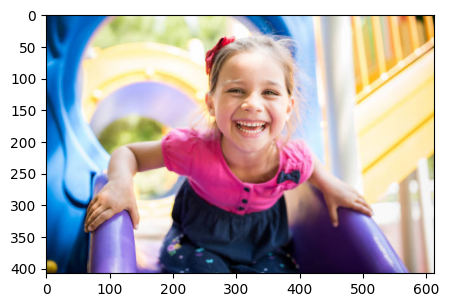

In [58]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences


new_image_path = "/Users/srisaijishnuedara/Documents/SEMESTER_6/ML_PROJECT/image_captioning/istockphoto-699899338-612x612.jpg"
new_image = cv2.imread(new_image_path)
new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)

# Preprocess the new image
new_image_feature = model.predict(np.expand_dims(new_image, axis=0)).reshape(1, 2048)

# Initialize the beam with the start token
beam = [{'sequence': ['startofseq'], 'score': 1.0}]

# Generate a caption using beam search
for _ in range(50):  # Maximum caption length
    candidates = []
    for b in beam:
        # Encoding the current sequence
        encoded = [count_words[word] for word in b['sequence']]
        encoded = pad_sequences([encoded], maxlen=34, padding='post', truncating='post')

        # Predict the next word for the current sequence
        predictions = final_model.predict([new_image_feature, encoded])[0]

        # Get top-k predictions
        top_indices = np.argsort(predictions)[-beam_width:]

        # Generate candidate captions
        for idx in top_indices:
            candidate = {
                'sequence': b['sequence'] + [inverse_dict[idx]],
                'score': b['score'] * predictions[idx]
            }
            candidates.append(candidate)

    # Select top-k candidates based on score
    beam = sorted(candidates, key=lambda x: x['score'], reverse=True)[:beam_width]

    # Check for end token in the beam
    end_found = False
    for b in beam:
        if b['sequence'][-1] == 'endofseq':
            end_found = True
            break

    if end_found:
        break

# Get the best caption from the beam
pred_caption = beam[0]['sequence']
pred_caption = pred_caption[1:-1]  # Remove start and end tokens
pred_caption = ' '.join(pred_caption)
print(pred_caption)
pred_caption = translate_to_telugu(pred_caption)
print(pred_caption)
print("\n")
# Visualize the new image and the predicted caption
plt.figure(figsize=(5, 5))
plt.imshow(new_image)
plt.show()

In [57]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences


new_image_path = "/Users/srisaijishnuedara/Documents/SEMESTER_6/ML_PROJECT/image_captioning/istockphoto-699899338-612x612.jpg"
new_image = cv2.imread(new_image_path)
new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)

# Preprocess the new image
new_image_feature = model.predict(np.expand_dims(new_image, axis=0)).reshape(1, 2048)

# Initialize the beam with the start token
beam = [{'sequence': ['startofseq'], 'score': 1.0}]

# Generate a caption using beam search
for _ in range(50):  # Maximum caption length
    candidates = []
    for b in beam:
        # Encoding the current sequence
        encoded = [count_words[word] for word in b['sequence']]
        encoded = pad_sequences([encoded], maxlen=34, padding='post', truncating='post')

        # Predict the next word for the current sequence
        predictions = final_model.predict([new_image_feature, encoded])[0]

        # Get top-k predictions
        top_indices = np.argsort(predictions)[-beam_width:]

        # Generate candidate captions
        for idx in top_indices:
            candidate = {
                'sequence': b['sequence'] + [inverse_dict[idx]],
                'score': b['score'] * predictions[idx]
            }
            candidates.append(candidate)

    # Select top-k candidates based on score
    beam = sorted(candidates, key=lambda x: x['score'], reverse=True)[:beam_width]

    # Check for end token in the beam
    end_found = False
    for b in beam:
        if b['sequence'][-1] == 'endofseq':
            end_found = True
            break

    if end_found:
        break

# Get the best caption from the beam
pred_caption = beam[0]['sequence']
pred_caption = pred_caption[1:-1]  # Remove start and end tokens
pred_caption = ' '.join(pred_caption)
print(pred_caption)
pred_caption = translate_to_telugu(pred_caption)
print(pred_caption)
print("\n")
# Visualize the new image and the predicted caption
plt.figure(figsize=(5, 5))
plt.imshow(new_image)
plt.show()

1/1 [==============================] - 0s 23ms/step
a little girl is wearing a black dress is climbing on a playground tunnel .


ConnectionError: HTTPConnectionPool(host='api.mymemory.translated.net', port=80): Max retries exceeded with url: /get?q=a+little+girl+is+wearing+a+black+dress+is+climbing+on+a+playground+tunnel+.&langpair=en%7Cte (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x28369ebc0>: Failed to resolve 'api.mymemory.translated.net' ([Errno 8] nodename nor servname provided, or not known)"))